In [42]:
# EMW:
# Reworked to only load 2 ions at a time 
# will be slower for small files but will hopefully make it possible to run with bigger files

In [16]:
# Functions and imports

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
# import cv2
import matplotlib.patches as patches
import pbasex
import abel
import multiprocessing as mp
from pbasex import pbasex, loadG
from quadrant import foldQuadrant, resizeFolded
from scipy import ndimage
from scipy.ndimage import gaussian_filter

def beautify(ax):
    
    ax.tick_params(axis = 'x', labelsize = 10)
    ax.tick_params(axis = 'y', labelsize = 10)
    ax.tick_params('both', length = 3, width = 1)
    ax.grid(linewidth = 1, alpha = 0.3)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)

def create_image(df, centre, ti = 0, tf = 0):
    
    if (ti & tf):
        df = df[(df['mz'] >= ti) & (df['mz'] <= tf)]
    image = np.zeros((324, 324))
    xy = df.groupby(['x', 'y']).size().reset_index(name = 'intensity') # computes the intensity for each xy coordinate
    results = (np.array(xy).astype(int))
    cx = 162 - centre[0]
    cy = 162 - centre[1]
    for a,b,c in results: # assigns the intensity (c) to each coordinate in the image
        if 0 <= (b + cx) < 324:
            if 0 <= (a + cy) < 324:
                image[b + cx, a + cy] = c
        
    return(image)

def create_image2(df, compress_fac, ti = 0, tf = 0):
    
    if (ti & tf):
        df = df[(df['mz'] >= ti) & (df['mz'] <= tf)]
    image = np.zeros((int(324/compress_fac), int(324/compress_fac)))
    xy = df.groupby(['x', 'y']).size().reset_index(name = 'intensity') # computes the intensity for each xy coordinate
    results = (np.array(xy).astype(int))
    cx = int(162/compress_fac)# - centre[0])
    cy = int(162/compress_fac)# - centre[1])
    for a,b,c in results: # assigns the intensity (c) to each coordinate in the image
        if 0 <= (b + cx) < 324/compress_fac:
            if 0 <= (a + cy) < 324/compress_fac:
                image[b + cx, a + cy] = c
        
    return(image)

def symmetrise(image, quadrant_filter, pixels):
    
    pixels = int(pixels/2)
    folded = resizeFolded(foldQuadrant(image, pixels, pixels, quadrant_filter), pixels)
    
    sym_image = np.zeros([324, 324])
    sym_image[0:162, 0:162] = np.flip(folded)
    sym_image[0:162, 162:324] = np.flip(folded, axis = 0)
    sym_image[162:324, 0:162] = np.flip(folded, axis = 1)
    sym_image[162:324, 162:324] = folded
    
    return(sym_image)


In [17]:
# 2D recoil-frame covariance function

from numba import jit 

@jit(nopython = True)
def recoil_frame_Sij_1(array_A, array_B, shot_array, pixels):
    
    Sij_array = np.zeros((pixels, pixels), dtype = np.int64)
    
    no_A = array_A.shape[0]
    no_B = array_B.shape[0]
    
    nshotsA, nshotsB = 0, 0
    nendA, nendB = 0, 0
    
    for shot in shot_array:
    
        A_in_shot, B_in_shot = False, False
        
        for test in range(nshotsA, no_A):
            if (array_A[test, 2] == shot):
                nshotsA = test
                A_in_shot = True
                break
        
        if A_in_shot:
            for test in range(nshotsA, no_A):
                if array_A[test, 2] > shot:
                    nendA = test
                    break

            for test in range(nshotsB, no_B):
                if (array_B[test, 2] == shot):
                    nshotsB = test
                    B_in_shot = True
                    break
        
        if B_in_shot:
            for test in range(nshotsB, no_B):
                if array_B[test, 2] > shot:
                    nendB = test
                    break
        
        if A_in_shot & B_in_shot:
            
            for i in range(nshotsA, nendA):
                rad_A = array_A[i, 0]
                theta_A = array_A[i, 1]

                for j in range(nshotsB, nendB):
                    rad_B = array_B[j, 0]
                    theta_B = array_B[j, 1]

                    theta_rel = theta_B - theta_A
                    
                    if theta_rel>2*np.pi:
                        theta_rel=theta_rel-2*np.pi
                    elif theta_rel<0:
                        theta_rel=theta_rel+2*np.pi

                    x = int(round(rad_B*np.cos(theta_rel) + pixels/2))
                    y = int(round(rad_B*np.sin(theta_rel) + pixels/2))

                    if (0 < x < pixels) and (0 < y < pixels): # if hit is within the image array
                        Sij_array[y-1, x-1] += int(1)
    
    return(Sij_array)

@jit(nopython = True)
def recoil_frame_Sij_2(array_A, array_B, shot_array, pixels, mean_A):
    
    Sij_array = np.zeros((pixels, pixels), dtype = np.float64)
    
    no_A = array_A.shape[0]
    no_B = array_B.shape[0]
    
    nshotsA, nshotsB = 0, 0
    nendA, nendB = 0, 0
    
    for shot in shot_array:
    
        A_in_shot, B_in_shot = False, False
        
        for test in range(nshotsA, no_A):
            if (array_A[test, 2] == shot):
                nshotsA = test
                A_in_shot = True
                break
        
        if A_in_shot:
            for test in range(nshotsA, no_A):
                if array_A[test, 2] > shot:
                    nendA = test
                    break

            for test in range(nshotsB, no_B):
                if (array_B[test, 2] == shot):
                    nshotsB = test
                    B_in_shot = True
                    break
        
        if B_in_shot:
            for test in range(nshotsB, no_B):
                if array_B[test, 2] > shot:
                    nendB = test
                    break
        
        if A_in_shot & B_in_shot:
            
            n_A_ions = (nendA - nshotsA)
            for i in range(nshotsA, nendA):
                rad_A = array_A[i, 0]
                theta_A = array_A[i, 1]

                for j in range(nshotsB, nendB):
                    rad_B = array_B[j, 0]
                    theta_B = array_B[j, 1]

                    theta_rel = theta_B - theta_A
                    
                    if theta_rel>2*np.pi:
                        theta_rel=theta_rel-2*np.pi
                    elif theta_rel<0:
                        theta_rel=theta_rel+2*np.pi

                    x = int(round(rad_B*np.cos(theta_rel) + pixels/2))
                    y = int(round(rad_B*np.sin(theta_rel) + pixels/2))

                    if (0 < x < pixels) and (0 < y < pixels): # if hit is within the image array
                        Sij_array[y-1, x-1] += mean_A/n_A_ions
    
    return(Sij_array)


@jit(nopython = True)
def recoil_frame_SiSj(reduced_array_A, reduced_array_B, pixels):
    
    SiSj_array = np.zeros((pixels, pixels), dtype = np.int64)
    
    no_A = reduced_array_A.shape[0]
    no_B = reduced_array_B.shape[0]
    
    for i in range(no_A): 
        rad_A = reduced_array_A[i, 0]
        theta_A = reduced_array_A[i, 1]
        count_A = reduced_array_A[i, 2]

        for j in range(no_B):
            rad_B = reduced_array_B[j, 0]
            theta_B = reduced_array_B[j, 1]
            count_B = reduced_array_B[j, 2]
            
#             if rad_A and rad_B:
            if 3:
        
                theta_rel = theta_B - theta_A
                if theta_rel > 2*np.pi:
                    theta_rel = theta_rel - 2*np.pi
                elif theta_rel < 0:
                    theta_rel = theta_rel + 2*np.pi

                x = int(round(rad_B*np.cos(theta_rel) + pixels/2))
                y = int(round(rad_B*np.sin(theta_rel) + pixels/2))

                if (0 < x < pixels) and (0 < y < pixels): # if hit is within the image array
                    SiSj_array[y-1, x-1] += int(count_A*count_B)
    
    return(SiSj_array)


def two_fold_recoil_frame_covariance(df_A, df_B, shot_list, pixels, norm = False):
    
    n_shots = len(shot_list)
    
    # Sij = <xy>
    
    start_time = time.time()
    
    A_array = df_A[['r', 'theta', 'shot']].values
    B_array = df_B[['r', 'theta', 'shot']].values
    
    shot_array_A = np.unique(df_A.shot)
    shot_array_B = np.unique(df_B.shot)
    
    shot_array = np.intersect1d(shot_array_A, shot_array_B)
    shot_array = shot_array.astype('int64')
    
    if norm:
        mean_A = len(df_A)/n_shots
        Sij = recoil_frame_Sij_2(A_array, B_array, shot_array, pixels, mean_A)
        Sij /= float(n_shots)
        
    else:
        Sij = recoil_frame_Sij_1(A_array, B_array, shot_array, pixels)
        Sij = Sij.astype('float64')
        Sij /= float(n_shots)
    
    print("Calculating Sij took %s seconds" % round((time.time() - start_time), 1))
    
    # SiSj = <x><y>
    
    start_time = time.time()
        
    df_A_count_series = df_A.groupby(['r', 'theta']).size()
    df_A_count_df_SiSj = df_A_count_series.to_frame(name = 'size').reset_index()

    df_B_count_series = df_B.groupby(['r', 'theta']).size()
    df_B_count_df_SiSj = df_B_count_series.to_frame(name = 'size').reset_index()

    A_array_SiSj = df_A_count_df_SiSj[['r', 'theta', 'size']].values
    B_array_SiSj = df_B_count_df_SiSj[['r', 'theta', 'size']].values

    SiSj = recoil_frame_SiSj(A_array_SiSj, B_array_SiSj, pixels)
    SiSj = SiSj.astype('float64')
    SiSj /= n_shots**2
    
    print("Calculating SiSj took %s seconds" % round((time.time()-start_time),1))
    
    return(Sij, SiSj)
    

In [22]:
os.chdir(r"\\chem.ox.ac.uk\Research\Vallance Claire\Zhihao\Data\SO2\400uJ\new_center")

label = 'SO2_400uJ_bg'
# label = 'run_20'

#ion_list = ['O+','O++'] #use this list when do the common covariance
ion_list = ['O++'] #use this ion list when try to do the self covariance
#ion_list_save = ['O+','O++']
ion_list_save = ['O++']

#pq_list_unsorted = [(0,1), (1,0)] #use this list when do the common covariance
pq_list_unsorted = [(0,0)] #use this list when do the self covariance

filesizes = []
for n, ion in enumerate(ion_list_save):
    filesizes.append(os.path.getsize(label+'_'+ion_list_save[n]+'.npy'))
    
print(filesizes)

files_sorted_desc=[n for f, n in sorted(zip(filesizes, np.arange(0,len(ion_list))),reverse=True)]
files_sorted_asc=[n for f, n in sorted(zip(filesizes, np.arange(0,len(ion_list))),reverse=True)]
print(files_sorted_desc)

# sort pq list by size of file [(biggest,biggest),(biggest, smallest),...,(biggest, 2nd biggest),(2nd biggest, smallest),... etc]
pq_list=[]
for a in files_sorted_desc:
    # self covariance first
    if (a,a)in pq_list_unsorted:
        pq_list.append((a,a))
    for b in files_sorted_asc:
        if (filesizes[b]<filesizes[a]) and ((a,b)in pq_list_unsorted): # keep first a, replace 2nd a with b
            pq_list.append((a,b))
        if (filesizes[b]<filesizes[a]) and (b,a)in pq_list_unsorted: # reverse which is a and which is b
            pq_list.append((b,a))
                        
print(pq_list)

[13301600]
[0]
[(0, 0)]


In [23]:
compress_fac = 1
pixels = int(324/compress_fac)
centre=int(162/compress_fac) # assumes pre-centered data

def process(df, compress_fac):   
    #compress
    df['x'] = (df['x']/compress_fac).astype('int64')-centre
    df['y'] = (df['y']/compress_fac).astype('int64')-centre
    df['mz'] = (df['mz']).astype('int64')
    df['shot'] = (df['shot']).astype('int64')
    # add columns
    df['r'] = np.sqrt((df['x'])**2 + (df['y'])**2)
    df['theta'] = np.arctan2(df['x'], df['y']) + np.pi
    
    return(df)

Covariance 1 of 1.
O++ & O++


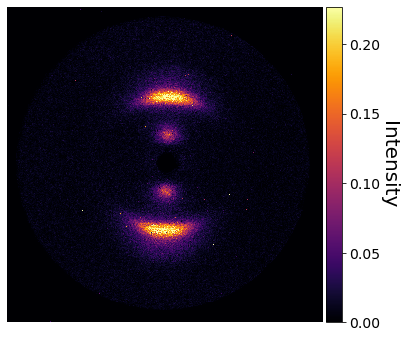

Calculating Sij took 0.1 seconds
Calculating SiSj took 96.4 seconds
Finished.


In [24]:
# Calculate covariances for 4x4 figures
from mpl_toolkits.axes_grid1 import make_axes_locatable
term_list = []

p_prev=np.inf
q_prev=np.inf
imaged=np.zeros((len(ion_list),),dtype=int)

for n, (p, q) in enumerate(pq_list):

    print('Covariance %s of %s.' % (n+1, len(pq_list)))
    print(ion_list_save[p]+' & '+ion_list_save[q])
    
    if p==q: # self covariance - only load data once
        if p==p_prev:
            #keep p, clear q
            df_q=None
        elif p==q_prev:
            #new p = old q, remove old q
            df_p=df_q
            df_q=None
        else:
            #clear old p & q, load new p
            df_q=None
#             file = np.load(ion_list_save[p]+'_'+timing+'.npy',allow_pickle=True)
            df_p = pd.DataFrame(np.load(label+'_'+ion_list_save[p]+'.npy',allow_pickle=True), columns = ['x','y','mz','shot'])
            df_p=process(df_p,compress_fac)
    else:
        if p==q_prev and q==p_prev:
            #swap
            df_p,df_q = df_q,df_p
        elif p==p_prev:
            #load new q
            df_q = pd.DataFrame(np.load(label+'_'+ion_list_save[q]+'.npy',allow_pickle=True), columns = ['x','y','mz','shot'])
            df_q=process(df_q,compress_fac)
        elif p==q_prev:
            #new p = old q, load new q
            df_p=df_q
            df_q = pd.DataFrame(np.load(label+'_'+ion_list_save[q]+'.npy',allow_pickle=True), columns = ['x','y','mz','shot'])
            df_q=process(df_q,compress_fac)
        else:
            #load both anew; applies for n=0            
            df_p = pd.DataFrame(np.load(label+'_'+ion_list_save[p]+'.npy',allow_pickle=True), columns = ['x','y','mz','shot'])
            df_p=process(df_p,compress_fac)
            df_q = pd.DataFrame(np.load(label+'_'+ion_list_save[q]+'.npy',allow_pickle=True), columns = ['x','y','mz','shot'])
            df_q=process(df_q,compress_fac)
    
    p_prev=p
    q_prev=q
    
    for a in (p,q):
        if imaged[a]==0:
            fig, ax = plt.subplots(figsize = (6, 6))
            if a==p:
                image = create_image2(df_p, compress_fac)
            elif a==q:
                image = create_image2(df_q, compress_fac)
            ax.imshow(image.T, cmap = 'inferno', vmax = 0.5*np.max(image), vmin = 0, origin = 'lower')

            find_centre = True
            '''if find_centre: # plot some crosshairs to help find image centre
                ax.axvline(162/2, color = 'white')
                ax.axhline(162/2, color = 'white')'''

            #ax.text(0.04, 0.88, ion_list[a], transform = ax.transAxes, fontsize = 30, color = 'white')
            ax.axis('off')
            
            image_data = image.T
            image_data[np.where(image_data < 0)] = 0
            image_data = np.divide(image_data, image_data.sum()) * 1000
            data_vmax = image_data.max()
            data_vmin = image_data.min()
            vmin_factor = 1  # keep at 1
            vmax_factor = 0.6  # decrease for higher contrast
            picture =ax.imshow(image_data, interpolation='nearest', cmap='inferno', origin='lower',
                       vmax=data_vmax * vmax_factor, vmin=data_vmin * vmin_factor)

            
            
            #v_max=np.max(image.T)
            #picture = ax.imshow(image.T, interpolation='nearest', cmap='inferno', vmin=0,vmax=v_max)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cax.tick_params(labelsize=14)
            plt.colorbar(picture,cax=cax,orientation='vertical').set_label(label='Intensity', size=20, labelpad=18, rotation =270)
            plt.savefig(label+'_'+ion_list[a]+'_ion_image.png',bbox_inches='tight')
            plt.show()
            
            
            imaged[a]=1


    
#   shot_list = np.arange(np.max(df.shot) + 1) # need to do something about this            
#     shot_list = np.unique(df_p.shot)
    shot_list = np.arange(np.max(df_p.shot) + 1)
    
    if p==q:
        Sij, SiSj = two_fold_recoil_frame_covariance(df_p, df_p, shot_list, pixels, norm = True)
    else:
        Sij, SiSj = two_fold_recoil_frame_covariance(df_p, df_q, shot_list, pixels, norm = True)
        
    term_list.append((Sij, SiSj))


print('Finished.')
    

1
0.999986081214812
yes


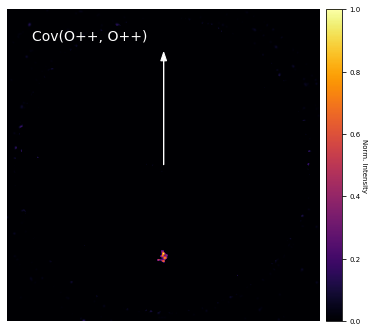

In [25]:
#FORMATTED regular/individual

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
# import cv2
import matplotlib.patches as patches
import pbasex
import abel
import multiprocessing as mp
from pbasex import pbasex, loadG
from quadrant import foldQuadrant, resizeFolded
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator


# compress_fac = 2
# pixels = int(324/compress_fac)

print(len(term_list))

os.chdir(r"\\chem.ox.ac.uk\Research\Vallance Claire\Zhihao\Data\SO2\400uJ\COV_recentre_MBB\bg_norm_no_compress") 


sub_fac_list = [1,1] # need one entry per ion pair, should just set this to 1


for (p, q), (Sij, SiSj), sub_fac in zip(pq_list, term_list, sub_fac_list):

    ion_A, ion_B = ion_list[p], ion_list[q]
    ionA, ionB = ion_list_save[p], ion_list_save[q]
    np.save(label+'_'+ionA+'_'+ionB+'_Sij.npy',Sij.T)
    np.save(label+'_'+ionA+'_'+ionB+'_SiSj.npy',SiSj.T)
    #apply subtraction fctor here. If we don't want it, just comment it.
    sub_fac = np.sum(Sij)/np.sum(SiSj)
    print(sub_fac)
#    sub_fac = 1.02

    covar = Sij - sub_fac*SiSj
    #covar = Sij - 0.999*SiSj
    #print(sub_fac )

    if p == q: # Remove autovariance signal
        print('yes')
        hlf_pxl = int(pixels/2) - 1
        #covar.T[162:324,150:170] = 0
        covar.T[hlf_pxl:pixels, hlf_pxl-20:hlf_pxl+20] = 0 
    x=[]
    y=[]
    I=[]
    for a in np.arange(len(covar)):
        for b in np.arange(len(covar[a])):
            x.append(a)
            y.append(b)
            I.append(covar[a,b])
    x = np.reshape(np.asarray(x), (-1,1))
    y = np.reshape(np.asarray(y), (-1,1))
    I = np.reshape(np.asarray(I), (-1,1))
    xyi=np.concatenate((x,y,I),axis=1)

    df_xyi=pd.DataFrame((xyi), columns=['x','y','i'])
    df_xyi['x']-=81
    df_xyi['y']-=81
    df_xyi['r'] = np.sqrt((df_xyi['x'])**2 + (df_xyi['y'])**2)
    df_xyi['theta'] = np.arctan2(df_xyi['x'], df_xyi['y']) + np.pi
    df_xyi['theta'] -=np.pi 
    df_xyi['theta'] /=np.pi
    df_xyi['theta']*=180
    df_theta = df_xyi.groupby(['theta'])['i'].sum().reset_index(name='intensity')
    df_theta=df_theta.loc[df_theta['intensity']>=0]
    fig, ax = plt.subplots(figsize=(6, 6))
    covar = gaussian_filter(covar, sigma = 1)
    covar/=np.max(covar)
    np.save(label+'_'+ionA+'_'+ionB+'_covar.npy',covar.T)
    np.savetxt(label+'_'+ionA+'_'+ionB+'_covar.dat',covar.T,delimiter='\t')
    cov_map=ax.imshow(covar.T, origin = 'lower', cmap = 'inferno',vmax=np.max(covar),vmin=0)
    ax.text(0.08, 0.9, 'Cov(%s, %s)' % (ion_A, ion_B), transform = ax.transAxes, fontsize = 14, color = 'white')
    ax.arrow(pixels/2, pixels/2, 0, pixels/3, color = 'white', linewidth = 1, head_width = 6/compress_fac)
    ax.axis('off')
    #ax.tick_params(axis = 'x', labelsize = 20)
    #ax.tick_params(axis = 'y', labelsize = 20)
    #ax.yaxis.set_major_locator(MaxNLocator(5))
    #ax.xaxis.set_major_locator(MaxNLocator(5)) 
    divider=make_axes_locatable(ax)
    cax=divider.append_axes('right',size='5.0%',pad=0.1)
    cax.tick_params(labelsize=7)
    plt.colorbar(cov_map,cax=cax,orientation='vertical').set_label(label='Norm. Intensity', size=7, labelpad=7, rotation =270)
    plt.savefig(label+'_'+ionA+'_'+ionB+'_covar.png',bbox_inches='tight')
    #plt.savefig('ch2i2_'+str(ion_A)+'_'+str(ion_B)+'_recoil_cov_sized.eps',bbox_inches='tight')
    
#     fig,ax2 = plt.subplots(figsize=(6,6))
#     bin_no=int(len(df_theta)/100)
#     hist = ax2.hist(df_theta.theta, bins=bin_no, weights=df_theta.intensity)
#     ax2.set_ylim(0,1.1*np.max(hist[0]))
#     ax2.text(0.42, 1, 'Angular (%s, %s)' % (ion_A, ion_B), transform = ax.transAxes, fontsize = 20, color = 'black')